<a href="https://colab.research.google.com/github/hhumayune/Fake-News-Detector/blob/master/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. IMPORTING LIBRARIES and DATASET

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model



true_path = 'https://raw.githubusercontent.com/sudhanshu976/-FAKE-NEWS-CLASSIFIER-USING-LSTM-WITH-WEB-APP/main/data/True.csv'
fake_path = 'https://raw.githubusercontent.com/sudhanshu976/-FAKE-NEWS-CLASSIFIER-USING-LSTM-WITH-WEB-APP/main/data/Fake.csv'

true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

In [ ]:
# Showing the datasets
display(true_df)
display(fake_df)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


### 2. EXPLORING REAL/TRUE DATA

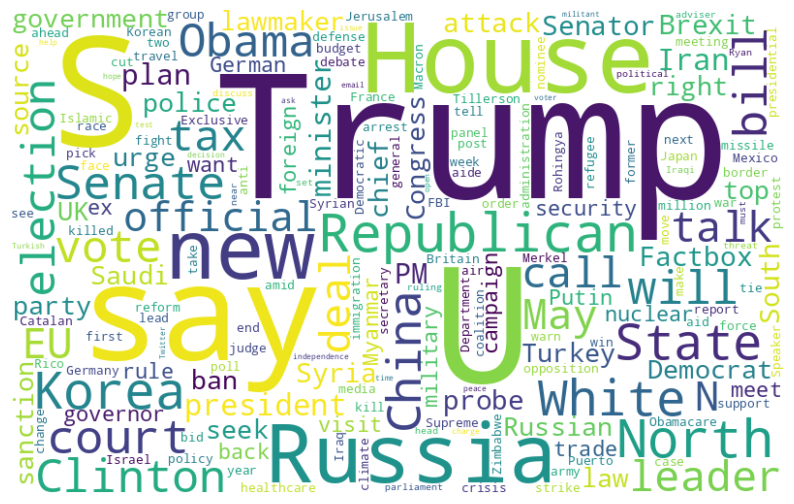

In [3]:
real_titles = true_df.title
real_titles_ls = [text for text in real_titles]


real_all_words = ' '.join(real_titles)
wordcloud_real = WordCloud(background_color='white',
    width= 800, height= 500,
    max_font_size = 180,
    collocations = False).generate(real_all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3. EXPLORING FAKE NEWS DATA

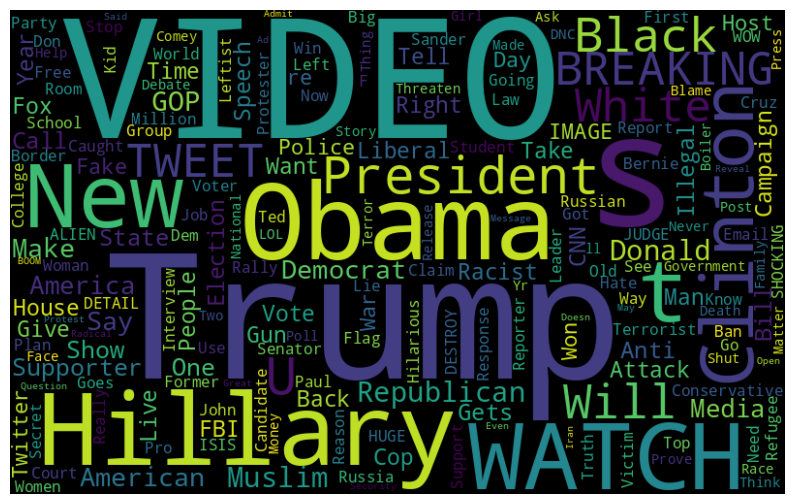

In [4]:
fake_titles = fake_df.title
fake_titles_ls = [text for text in fake_titles]


fake_all_words = ' '.join(fake_titles)
wordcloud_fake = WordCloud(background_color='black',
    width= 800, height= 500,
    max_font_size = 180,
    collocations = False).generate(fake_all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. SOME MORE INSIGHTS ON DATA

In [5]:
true_df["subject"].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

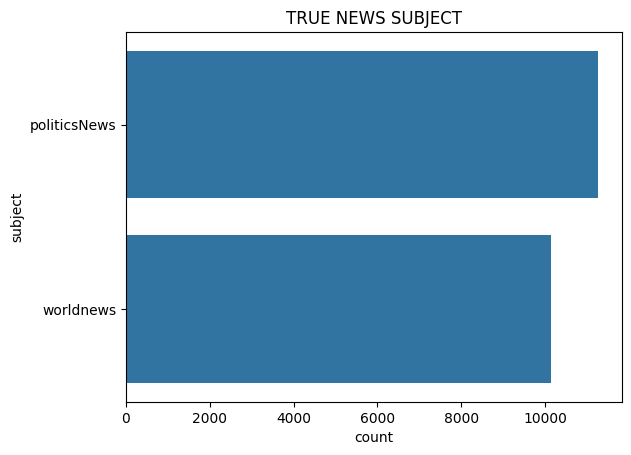

In [8]:
sns.countplot(y="subject", data=true_df)
plt.title("TRUE NEWS SUBJECT")
plt.show()

In [9]:
fake_df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

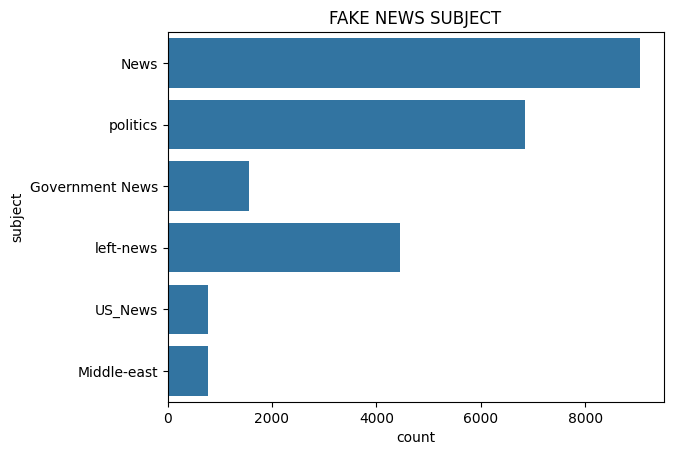

In [10]:
sns.countplot(y="subject",data=fake_df)
plt.title("FAKE NEWS SUBJECT")
plt.show()

### 5. PREPROCESSING OF DATA

In [11]:
# Labelling the data before concatting them
true_df['true'] = 1
fake_df['true'] = 0


# Concatting both true_df and fake_df
df = pd.concat([true_df, fake_df])

# Keeping only titile Column
df = df.iloc[:,[0, -1]]

# Data Shuufling for Randomness
df = shuffle(df).reset_index(drop=True)

display(df)


,title,true
0,Senate Democrats want changes to House Republi...,1
1,Bristol Palin Points Out She’s NOT A Graduate...,0
2,Trump Says As President He’ll Actively Sue An...,0
3,"In Flint, Sanders says water crisis should ser...",1
4,Ted Cruz Is Forced To Explain His Bigotry To ...,0
...,...,...
44893,Ohio's 'dirty little secret': blue-collar Demo...,1
44894,Yemen cholera cases could hit 1 million by yea...,1
44895,'Bridgegate' names can remain secret: U.S. app...,1
44896,LOL! LEADER OF “Do-Nothing Senate” Mitch McCon...,0


In [12]:
# Preprocessing function for making text more good and clean

def preprocess_text(text):
    # Replace characters that are not between a to z or A to Z with whitespace
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Convert all characters into lower-case ones.
    text = text.lower()

    # Remove inflectional morphemes like "ed", "est", "s", and "ing" from their token stem
    text = re.sub('(ed|est|s|ing)$', '', text)
    return text

# Apply preprocessing to the title column
df['title'] = df['title'].apply(preprocess_text)
display(df)

,title,true
0,senate democrats want changes to house republi...,1
1,bristol palin points out she s not a graduate...,0
2,trump says as president he ll actively sue an...,0
3,in flint sanders says water crisis should ser...,1
4,ted cruz is forced to explain his bigotry to ...,0
...,...,...
44893,ohio s dirty little secret blue collar demo...,1
44894,yemen cholera cases could hit million by yea...,1
44895,bridgegate names can remain secret u s app...,1
44896,lol leader of do nothing senate mitch mccon...,0


### 6. SPLITTING DATA INTO TRAINING , VALIDATION AND TEST DATATSET

In [13]:
train_val_df = df.sample(frac = 0.8)
test_df = df.drop(train_val_df.index)

train_df = train_val_df.sample(frac = 0.8)
val_df = train_val_df.drop(train_df.index)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print('trainset size:', train_df.shape)
print('valset size:', val_df.shape)
print('testset size:', test_df.shape)


trainset size: (28734, 2)
valset size: (7184, 2)
testset size: (8980, 2)


### 7. SAVING THE TRAIN , VAL AND TEST DATATSET

In [14]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

### 8. CONCATTING THE DATASET AGAIN

In [15]:
df = pd.concat([train_df, val_df, test_df])
display(df)

,title,true
0,tim kaine reveals who s trying to steal the e...,0
1,triggered former cia agent trey gowdy ought...,0
2,trump hotels asked for people s favorite trav...,0
3,odebrecht says dealings with peru president we...,1
4,trump just called americans his enemies in ...,0
...,...,...
8975,mother writes scathing letter to hillary you...,0
8976,college threatens women who don t want to urin...,0
8977,exclusive trump says he does not fault son fo...,1
8978,us gov t war on rt imperial media truth mon...,0


### 9. MODEL TRAINING

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
sequences = tokenizer.texts_to_sequences(df['title'])

max_sequence_length = 42

# Input and target features
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = df['true']

# Model building
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history=model.fit(X, y, batch_size=32, epochs=3, validation_split=0.2)
model.save('news_classifier.h5')



Epoch 1/3
1123/1123 [==============================] - 70s 61ms/step - loss: 0.1245 - accuracy: 0.9510 - val_loss: 0.0789 - val_accuracy: 0.9698
Epoch 2/3
1123/1123 [==============================] - 70s 62ms/step - loss: 0.0375 - accuracy: 0.9871 - val_loss: 0.0931 - val_accuracy: 0.9679
Epoch 3/3
1123/1123 [==============================] - 68s 60ms/step - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.0958 - val_accuracy: 0.9704


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 10. EVALUATING THE TRAINED MODEL

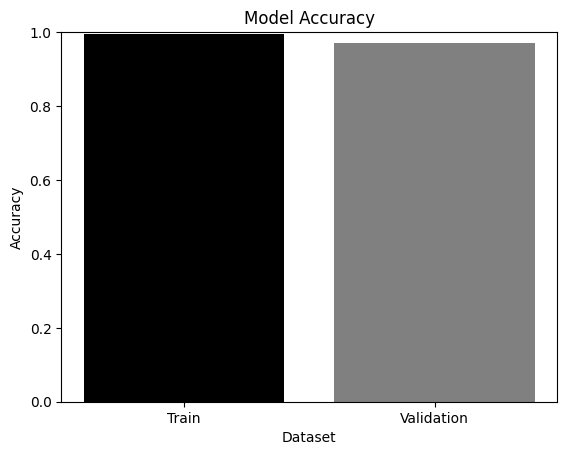

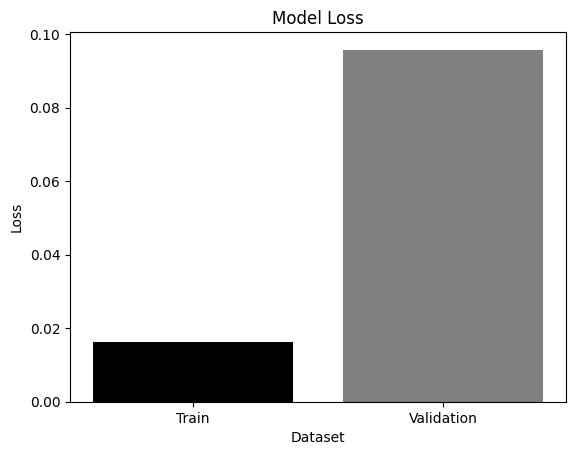

In [18]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.bar(['Train', 'Validation'], [history.history['accuracy'][-1], history.history['val_accuracy'][-1]], color=['black', 'grey'])
plt.title('Model Accuracy')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

# Plot loss
plt.bar(['Train', 'Validation'], [history.history['loss'][-1], history.history['val_loss'][-1]], color=['black', 'grey'])
plt.title('Model Loss')
plt.xlabel('Dataset')
plt.ylabel('Loss')
plt.show()



### 11. PREDICTING NEW NEWS INPUT USING SAVED MODEL

In [19]:
#For checking results
title_input = input("Enter a news title: ")

# Preprocess the title
preprocessed_title = preprocess_text(title_input)

# Tokenize and pad the preprocessed title
sequence = tokenizer.texts_to_sequences([preprocessed_title])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)

# Load the saved model
loaded_model = load_model('news_classifier.h5')

# Prediction
prediction = loaded_model.predict(padded_sequence)[0]

# Print the result
if prediction >= 0.5:
    print("REAL NEWS")
else:
    print("FAKE NEWS")


Enter a news title: senate democrats want changes to house republic
1/1 [==============================] - 0s 300ms/step
REAL NEWS
